# Assignment Overview


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Load the data
df_original = pd.read_excel('FarTrend_eRetail.xlsx')

In [3]:
# Create a copy of the original dataframe to save loading time
df = df_original.copy()

## Question 1: Data Quality and Customer Understanding (30 points)

#### Q1.1 Please perform the exploratory data analysis of the data. (20 points)


### First look

In [4]:
# Initial analysis
# Check basic properties of the dataframe
print("Length of the dataframe:", len(df))
print("Number of columns:", len(df.columns))
for col in df.columns:
    print(f"Column name: {col}, Data type: {df[col].dtype}")
df.head()

Length of the dataframe: 541909
Number of columns: 8
Column name: InvoiceNo, Data type: object
Column name: StockCode, Data type: object
Column name: Description, Data type: object
Column name: Quantity, Data type: int64
Column name: InvoiceDate, Data type: datetime64[ns]
Column name: UnitPrice, Data type: float64
Column name: CustomerID, Data type: float64
Column name: Country, Data type: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Duplicates and missing values

In [5]:
# Check for duplicates and missing values
# Check for duplicates
print("Count of duplicated data in the dataframe:", df.duplicated().sum())
print("Count of duplicated data in the InvoiceNo column:", df['InvoiceNo'].duplicated().sum())
print("-------------------------------------------------")

# Number and percentage of missing values according to columns
print("Number and percentage of missing values according to columns:")
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

Count of duplicated data in the dataframe: 5268
Count of duplicated data in the InvoiceNo column: 516009
-------------------------------------------------
Number and percentage of missing values according to columns:


{'Description': [1454, '% 0.268'], 'CustomerID': [135080, '% 24.927']}

In [6]:
# Dealing with duplicates and missing values
# Drop duplicated rows
df.drop_duplicates(inplace=True)

# Drop rows with missing CustomerID, since this ID is crucial for later analysis
df.dropna(subset=['CustomerID'], inplace=True)

#Fill missing Description with 'Missing', since these rows could hold valuable information despite the missing description
df['Description'].fillna('Missing', inplace=True)

### Date sense check

In [7]:
# Sense check for invoice date, it is normal with no corrupted data
print("Minimum Invoice Date:", df['InvoiceDate'].min())
print("Maximum Invoice Date:", df['InvoiceDate'].max())

Minimum Invoice Date: 2010-12-01 08:26:00
Maximum Invoice Date: 2011-12-09 12:50:00


### Country sense check

In [8]:

country_counts = df['Country'].value_counts()
country_percentages = df['Country'].value_counts(normalize=True) * 100

for country, count in zip(country_counts.index, country_counts.values):
    percentage = country_percentages[country]
    print(f"Country: {country}, Count: {count}, Percentage: {percentage:.2f}%")


Country: United Kingdom, Count: 356728, Percentage: 88.83%
Country: Germany, Count: 9480, Percentage: 2.36%
Country: France, Count: 8475, Percentage: 2.11%
Country: EIRE, Count: 7475, Percentage: 1.86%
Country: Spain, Count: 2528, Percentage: 0.63%
Country: Netherlands, Count: 2371, Percentage: 0.59%
Country: Belgium, Count: 2069, Percentage: 0.52%
Country: Switzerland, Count: 1877, Percentage: 0.47%
Country: Portugal, Count: 1471, Percentage: 0.37%
Country: Australia, Count: 1258, Percentage: 0.31%
Country: Norway, Count: 1086, Percentage: 0.27%
Country: Italy, Count: 803, Percentage: 0.20%
Country: Channel Islands, Count: 757, Percentage: 0.19%
Country: Finland, Count: 695, Percentage: 0.17%
Country: Cyprus, Count: 611, Percentage: 0.15%
Country: Sweden, Count: 461, Percentage: 0.11%
Country: Austria, Count: 401, Percentage: 0.10%
Country: Denmark, Count: 389, Percentage: 0.10%
Country: Japan, Count: 358, Percentage: 0.09%
Country: Poland, Count: 341, Percentage: 0.08%
Country: USA, 

Almost 90% of the transactions are from the United Kingdom, a UK vs non-UK binary variable makes sense.

In [9]:
df['IsUK'] = np.where(df['Country'] == 'United Kingdom', 1, 0)

# Check if there are customers with both 0s and 1s in the 'IsUK' column
has_both_zeros_and_ones = df.groupby('CustomerID')['IsUK'].nunique().gt(1).any()
print(has_both_zeros_and_ones)

False


Each customer has made purchases either only in the United Kingdom or only outside the United Kingdom.

### Customer ID sense check

In [10]:
# All customer IDs are the same length
unique_lengths = df['CustomerID'].astype(str).str.len().unique()
print(unique_lengths)

[7]


### StockCode sense check

In [11]:
# Looking at the to 10 stock codes
top_10_stockcodes = df['StockCode'].value_counts().head(10)
print(top_10_stockcodes)

StockCode
85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
20725     1346
22720     1224
POST      1196
22197     1110
23203     1108
Name: count, dtype: int64


It seems that every stock code has exactly 5 numeric values, it makes sense to check for cases that don't.

In [12]:
# Get the unique StockCodes
unique_stockcodes = df['StockCode'].unique()

# Initialize a list to store the filtered StockCodes
filtered_stockcodes = []

# Iterate over the unique StockCodes
for stockcode in unique_stockcodes:
    # Check the number count in the StockCode
    digit_count = sum(char.isdigit() for char in str(stockcode))
    
    # Check if the number count is different from the expected count (5 in this case)
    if digit_count != 5:
        filtered_stockcodes.append(stockcode)

# Calculate the percentage of filtered StockCodes
percentage = len(df[df['StockCode'].isin(filtered_stockcodes)]) / len(df) * 100

# Print the filtered StockCodes and their percentage
print("Filtered StockCodes:")
print(filtered_stockcodes)
print(f"\nPercentage of filtered StockCodes: {percentage:.4f}%")


Filtered StockCodes:
['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

Percentage of filtered StockCodes: 0.4768%


They take very little percentage, and these do not seem real products, but occasional charges, so it makes sense to delete them.

In [13]:
# Drop the rows with filtered StockCodes
df = df[~df['StockCode'].isin(filtered_stockcodes)]

### Cancelations

In [14]:
# Creating a flag for canceled and further investigation
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['Canceled'] = df['InvoiceNo'].apply(lambda x: 1 if str(x)[0] == 'C' else 0)
percentage_canceled = (df['Canceled'] == 1).mean() * 100
canceled_count = df['Canceled'].sum()
print("Count of Canceled transactions:", canceled_count)
print(f"Percentage of Canceled = 1: {percentage_canceled}%")
canceled_rows = df[df['Canceled'] == 1].head(10)
canceled_rows.head()

Count of Canceled transactions: 8506
Percentage of Canceled = 1: 2.128154640232781%


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsUK,Canceled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,1


Canceled transactions are present with negative quantities

In [15]:
print(len(df))
df = df[~((df['Quantity'] < 0) & (df['Canceled'] == 0))]
print(len(df))

399689
399689


No transactions that are not canceled and have negative quantity.

### Sense check unit price + transaction values

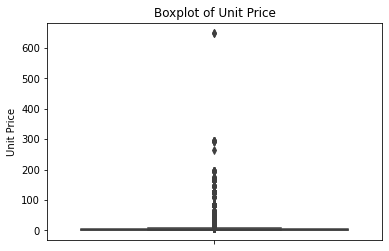

In [16]:
# Plotting data
sns.boxplot(data=df, y='UnitPrice')
plt.title('Boxplot of Unit Price')
plt.ylabel('Unit Price')
plt.show()

In [17]:
# Check for negative prices
negative_unit_prices = df[df['UnitPrice'] < 0]
if len(negative_unit_prices) > 0:
    print("There are negative values in the unit price column.")
else:
    print("There are no negative values in the unit price column.")

There are no negative values in the unit price column.


In [18]:
top_20_unit_prices = df.nlargest(20, 'UnitPrice')
top_20_unit_prices.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsUK,Canceled
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,1,0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,1,0
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,1,0
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,1,0
36165,C539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607.0,United Kingdom,1,1
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,1,0
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842.0,United Kingdom,1,0
87141,C543632,22655,VINTAGE RED KITCHEN CABINET,-1,2011-02-10 16:22:00,295.0,14842.0,United Kingdom,1,1
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452.0,United Kingdom,1,0
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452.0,United Kingdom,1,0


In [19]:
# Count 0 unit prices
count_zero_unit_prices = df[df['UnitPrice'] == 0]['UnitPrice'].count()
print(f"Count of 0 unit prices: {count_zero_unit_prices}")
# Print rows with 0 unit prices
rows_with_zero_unit_prices = df[df['UnitPrice'] == 0]
rows_with_zero_unit_prices.head()


Count of 0 unit prices: 33


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsUK,Canceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,1,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,1,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,1,0


In [20]:
# Drop rows with 0 unit prices
df = df[df['UnitPrice'] != 0]

In [21]:
# Calculate transcaction amount
df['TransactionAmount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsUK,Canceled,TransactionAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,20.34


### Create dataset for customer metrics

Since one of the main goals of this analysis is to cluster customers, I create a dataframe with meaningful metrics for each unique customer.

In [22]:
# Calculate 'TransactionAmount'
df['TransactionAmount'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg({
    'Quantity': ['mean', 'sum'],
    'UnitPrice': ['mean', 'sum'],
    'TransactionAmount': ['mean', 'sum']  # Add 'TransactionAmount'
}).reset_index()

# Flatten the MultiIndex in columns
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]

# Rename the columns
customer_df.rename(columns={
    'CustomerID_': 'CustomerID',
    'Quantity_mean': 'Quantity_Avg_Customer',
    'Quantity_sum': 'Quantity_Sum_Customer',
    'UnitPrice_mean': 'UnitPrice_Avg_Customer',
    'UnitPrice_sum': 'UnitPrice_Sum_Customer',
    'TransactionAmount_mean': 'TransactionAmount_Avg_Customer',  # Add 'TransactionAmount'
    'TransactionAmount_sum': 'TransactionAmount_Sum_Customer'  # Add 'TransactionAmount'
}, inplace=True)

# RECENCY - to see when was the last purchase
# Calculate the Recency metric for each customer
# Define max_date as the latest date in 'InvoiceDate'
max_date = df['InvoiceDate'].max()
recency_df = (max_date - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days.reset_index()
recency_df.columns = ['CustomerID', 'Recency']

# Merge recency_df with customer_df
customer_df = pd.merge(customer_df, recency_df, on='CustomerID')

# UNIQUE PRODUCTS - to see how many unique products were bought by each customer
# Calculate the number of unique products bought by each customer
unique_products_per_customer = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_per_customer.columns = ['CustomerID', 'UniqueProducts']

# Merge the unique_products_per_customer dataframe with the customer_df dataframe
customer_df = pd.merge(customer_df, unique_products_per_customer, on='CustomerID')

# PURCHASE COUNT - to see how many purchases were made by each customer
purchase_count = df.groupby('CustomerID')['InvoiceNo'].count()
purchase_count.columns = ['CustomerID', 'PurchaseCount']

# Merge the purchase_count dataframe with the customer_df dataframe
customer_df = pd.merge(customer_df, purchase_count, on='CustomerID')
customer_df.rename(columns={'InvoiceNo': 'PurchaseCount'}, inplace=True)

# AVERAGE DAYS BETWEEN PURCHASES - to see how often customers make purchases
# Calculate the average days between purchases
df_sorted = df.sort_values(['CustomerID', 'InvoiceDate'])
df_sorted['DaysBetweenPurchases'] = df_sorted.groupby('CustomerID')['InvoiceDate'].diff().dt.days

# Calculate the average days between purchases for each customer
average_days_between_purchases = df_sorted.groupby('CustomerID')['DaysBetweenPurchases'].mean().reset_index()
average_days_between_purchases.columns = ['CustomerID', 'AvgDaysBetweenPurchases']

# Merge the average days between purchases to the customer_df dataframe
customer_df = pd.merge(customer_df, average_days_between_purchases, on='CustomerID')

# USUAL SHOPPING DAY AND HOUR - to see when customers usually shop
# Calculate the usual shopping day for each customer
usual_shopping_day = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.dt.dayofweek.mode()[0]).reset_index()
usual_shopping_day.columns = ['CustomerID', 'UsualShoppingDay']

# Join the usual shopping day to the customer_df DataFrame
customer_df = pd.merge(customer_df, usual_shopping_day, on='CustomerID')

# USUAL SHOPPING HOUR - to see when customers usually shop
# Calculate the usual shopping hour for each customer
usual_shopping_hour = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.dt.hour.mode()[0]).reset_index()
usual_shopping_hour.columns = ['CustomerID', 'UsualShoppingHour']

# Join the usual shopping hour to the customer_df DataFrame
customer_df = pd.merge(customer_df, usual_shopping_hour, on='CustomerID')

# CANCELLATION COUNT - to see how many cancellations were made by each customer
# Calculate the count of cancellations for each customer
cancelation_count = df[df['Canceled'] == 1].groupby('CustomerID')['Canceled'].count().reset_index()
cancelation_count.columns = ['CustomerID', 'CancelationCount']

# Merge the cancelation_count DataFrame with the customer_df DataFrame
customer_df = pd.merge(customer_df, cancelation_count, on='CustomerID')

# CANCELLATION RATE - to see the percentage of cancellations for each customer
# Calculate the cancellation rate for each customer
customer_df['CancellationRate'] = customer_df['CancelationCount'] / customer_df['PurchaseCount']

# GEOGRAPHICAL FEATURE - to see if the customer is from the UK
# Add a georaphical feature
ukdf = df.groupby('CustomerID')['IsUK'].mean().reset_index()
customer_df = pd.merge(customer_df, ukdf, on='CustomerID')

customer_df.head()

,CustomerID,Quantity_Avg_Customer,Quantity_Sum_Customer,UnitPrice_Avg_Customer,UnitPrice_Sum_Customer,TransactionAmount_Avg_Customer,TransactionAmount_Sum_Customer,Recency,UniqueProducts,PurchaseCount,AvgDaysBetweenPurchases,UsualShoppingDay,UsualShoppingHour,CancelationCount,CancellationRate,IsUK
0,12346.0,0.000000,0,1.040000,2.08,0.000000,0.00,325,1,2,0.000000,1,10,1,0.500000,1.0
1,12352.0,5.511905,463,3.934524,330.50,15.064405,1265.41,35,57,84,3.108434,1,14,7,0.083333,0.0
2,12359.0,6.370518,1599,8.805020,2210.06,24.633386,6182.98,7,214,251,1.284000,3,12,6,0.023904,0.0
3,12362.0,8.257576,2180,3.523826,930.29,17.672652,4665.58,2,200,264,1.091255,3,15,8,0.030303,0.0
4,12375.0,10.937500,175,2.475000,39.60,23.463750,375.42,2,13,16,6.333333,4,14,1,0.062500,0.0


In [23]:
{col: [customer_df[col].isnull().sum(), f'% {np.round(np.mean(customer_df[col].isnull())*100, 3)}'
      ] for col in customer_df.columns if customer_df[col].isnull().any()}

{'AvgDaysBetweenPurchases': [11, '% 0.717']}

One time purchaser customers have missing average days between purchases. Since there are only 11 costumers that are one time purchasers, they will be removed from the data.

In [24]:
customer_df.dropna(subset=['AvgDaysBetweenPurchases'], inplace=True)
{col: [customer_df[col].isnull().sum(), f'% {np.round(np.mean(customer_df[col].isnull())*100, 3)}'
      ] for col in customer_df.columns if customer_df[col].isnull().any()}

{}

### Detecting and handeling outliers

To identify outliers in this multidimensional data, I applied an algorithm called isolation forest: Isolation forest represents a method for identifying outliers within datasets by employing a tree-like structure that randomly partitions the data space. Unlike traditional decision trees that ask specific questions about data attributes, isolation trees segment data groups based on randomized characteristics, thereby isolating potential anomalies or outliers. This approach proves particularly advantageous in scenarios involving multidimensional data, where traditional methods, like IQR, may struggle due to the complexity and dimensionality of the dataset. By efficiently detecting outliers without the need for exhaustive computations or complex distance calculations, isolation forest offers a streamlined and effective means of outlier detection, conducive to informed decision-making and problem identification in business contexts.

In [25]:
from sklearn.ensemble import IsolationForest

# Initializing the IsolationForest model with a contamination parameter of 0.05 - about 5% of the data is expected to be outliers
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on the dataset
customer_df['Outlier_Scores'] = model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_df['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_df['Outlier_Scores']]

# Calculating the percentage of outliers
percentage_outliers = (customer_df['Is_Outlier'].sum() / len(customer_df)) * 100

# Printing the percentage of outliers
print(f"Percentage of outliers: {percentage_outliers:.2f}%")

Percentage of outliers: 5.06%


Since clustering algorithms are very sensitive to outlier data, it makes sense to delete these rows from the customer data.

In [26]:
customer_df = customer_df.drop(customer_df[customer_df['Is_Outlier'] == 1].index)
customer_df = customer_df.drop(['Outlier_Scores', 'Is_Outlier'], axis=1)

### Distributions

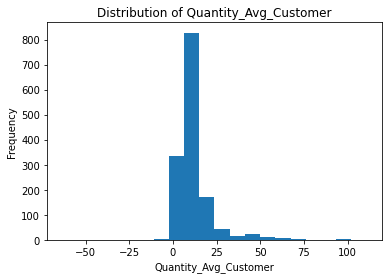

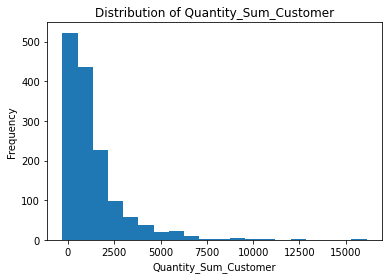

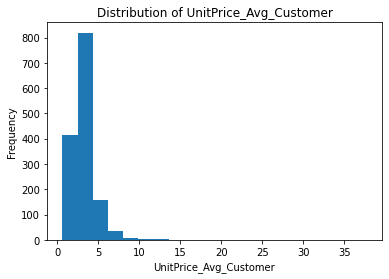

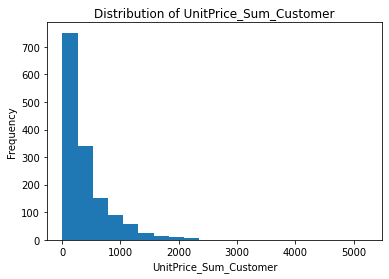

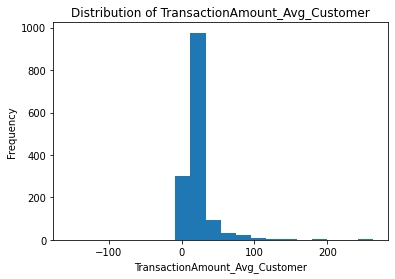

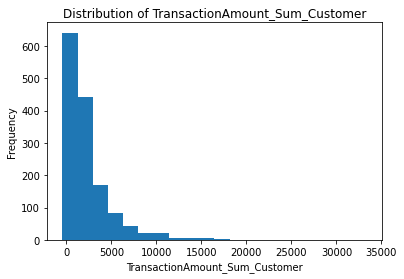

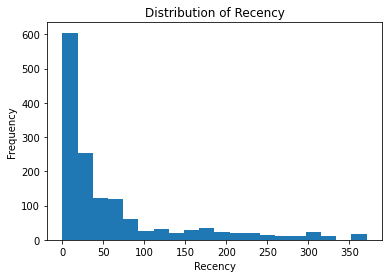

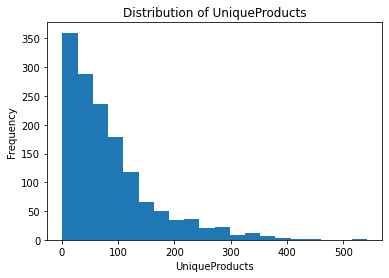

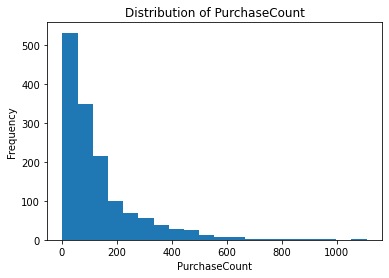

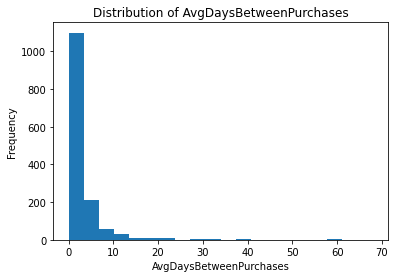

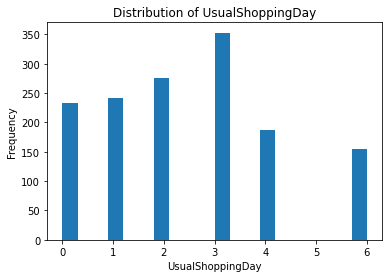

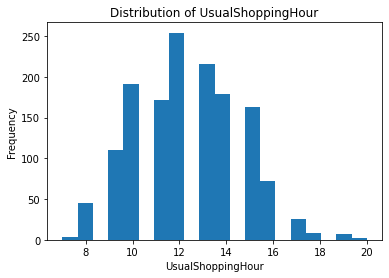

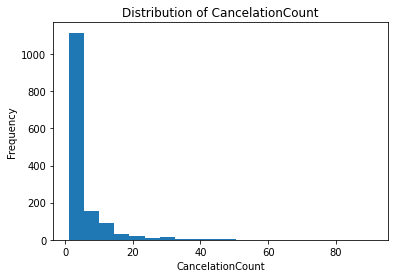

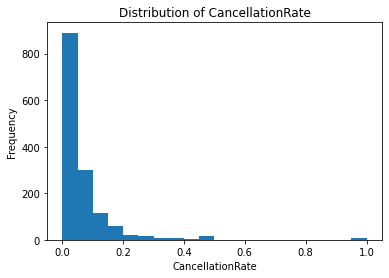

In [27]:
import matplotlib.pyplot as plt

# Exclude the 'IsUK' column
numeric_columns = customer_df.columns.drop(['IsUK', 'CustomerID'])

# Plot histograms for each numeric column
for column in numeric_columns:
    plt.figure()
    plt.hist(customer_df[column], bins=20)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.show()


### Correlations

<Axes: >

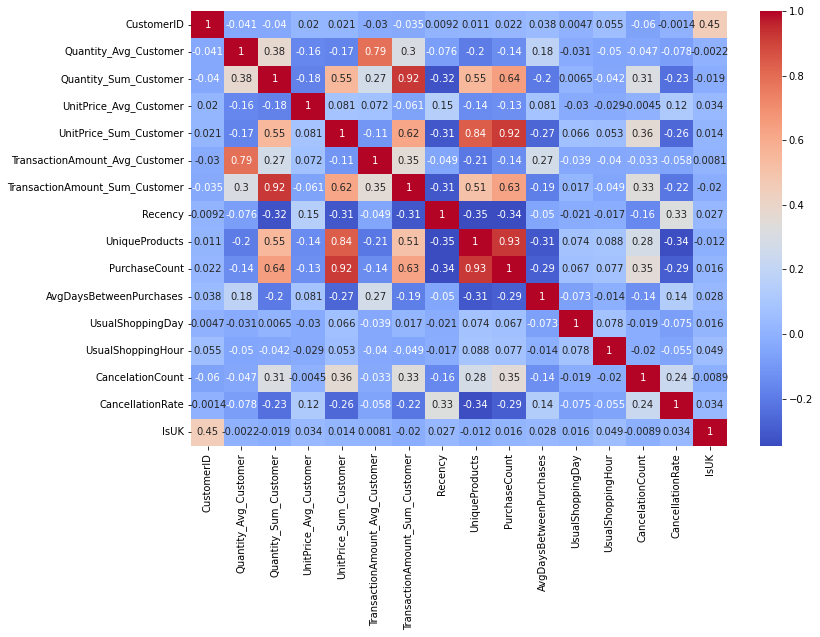

In [28]:
import seaborn as sns

# Generate the correlation matrix
corr_matrix = customer_df.corr()

plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [29]:
# Count unique number of customers and products
print("Number of unique Customer IDs:", df['CustomerID'].nunique())
print("Number of unique Stock Codes:", df['StockCode'].nunique())

Number of unique Customer IDs: 4362
Number of unique Stock Codes: 3676


#### Q1.2 Please describe in two paragraphs the main data insights. Connect the insight with the business  (10 points)


The dataset provides valuable insights into the transactional behavior of FarTrend's customers, comprising 4362 distinct individuals who have engaged in purchasing 3676 unique products offered by the company. A notable observation is the prevalence of frequent buyers within the customer base, with many customers demonstrating recurring purchase behavior. Interestingly, while the majority of customers focus on a smaller subset of unique products, there are outliers who exhibit a broader range of purchase interests, suggesting diverse preferences among FarTrend's clientele. Furthermore, the analysis indicates that the average transaction value tends to remain below 5000, with variations influenced by the quantity ordered. Remarkably, despite the opportunity to cancel orders, cancellation rates are minimal, constituting only 2% of the dataset. While there is a correlation between order count and cancellation count, the cancellation rate remains consistent, hinting at potential order processing errors rather than deliberate cancellations.

In the context of FarTrend's dataset, these insights provide tangible opportunities for optimizing marketing strategies and operational efficiencies. By recognizing the prevalence of recurring purchases and the diversity in product interests among customers, FarTrend can tailor its product offerings and promotional efforts to cater to specific customer segments. For instance, understanding that many customers focus on a smaller subset of unique products suggests potential opportunities for targeted product recommendations or bundling strategies to encourage exploration of other product categories. Moreover, the minimal cancellation rates observed in the dataset indicate a high level of customer satisfaction and confidence in FarTrend's products and services. This insight underscores the company's operational efficiency and provides valuable feedback for refining order processing workflows and customer service protocols. Overall, leveraging these data-driven insights enables FarTrend to enhance customer engagement, drive repeat purchases, and foster long-term customer loyalty, ultimately contributing to sustainable growth and success in the competitive e-commerce market.

## Question 2: Segment the clients based on their purchase profile (35 points)

#### Q2.1 Build a baseline model to segment the costumers. (15 points)

K-means clustering is a popular unsupervised learning algorithm used to partition data points into distinct clusters based on their similarity. Unlike hierarchical clustering, k-means requires the number of clusters (k) to be specified beforehand. The algorithm starts by randomly selecting k centroids, which serve as the initial cluster centers. It then iteratively assigns each data point to the nearest centroid and recalculates the centroids based on the mean of the data points assigned to each cluster. This process continues until the centroids stabilize and the clusters become optimized. K-means aims to minimize the within-cluster variance, ensuring that data points within the same cluster are as similar to each other as possible while being dissimilar to data points in other clusters. It is computationally efficient and scalable, making it suitable for large datasets.

In [30]:
from sklearn.preprocessing import StandardScaler

# Create a modeling dataframe by dropping the CustomerID
modeling_df = customer_df.drop('CustomerID', axis=1)

# Select the columns to apply standard scaling, IsUK is a binary column and does not need scaling, UsualShoppingHour and UsualShoppingDay are also excluded due to their nature
# k-means is sensitive to the scale of the data, so it is important to scale the data before applying k-means
columns_to_scale = modeling_df.columns.difference(['IsUK', 'UsualShoppingHour', 'UsualShoppingDay'])

# Apply standard scaling to the selected columns
scaler = StandardScaler()
modeling_df[columns_to_scale] = scaler.fit_transform(modeling_df[columns_to_scale])

modeling_df

,Quantity_Avg_Customer,Quantity_Sum_Customer,UnitPrice_Avg_Customer,UnitPrice_Sum_Customer,TransactionAmount_Avg_Customer,TransactionAmount_Sum_Customer,Recency,UniqueProducts,PurchaseCount,AvgDaysBetweenPurchases,UsualShoppingDay,UsualShoppingHour,CancelationCount,CancellationRate,IsUK
0,-1.095675,-0.844705,-1.308498,-0.920305,-0.999601,-0.808780,3.251088,-1.088294,-0.931263,-0.600665,1,10,-0.552484,4.172713,1.0
1,-0.591380,-0.553882,0.376540,-0.152939,-0.293096,-0.374466,-0.310889,-0.363385,-0.334463,-0.028249,1,14,0.349369,0.149158,0.0
2,-0.512824,0.159671,3.211884,4.238723,0.155679,1.313341,-0.654804,1.668948,0.880971,-0.364217,3,12,0.199060,-0.424719,0.0
3,-0.340173,0.524613,0.137453,1.248492,-0.170772,0.792539,-0.716218,1.487721,0.975586,-0.399711,3,15,0.499678,-0.362930,0.0
4,-0.094982,-0.734782,-0.473117,-0.832638,0.100824,-0.679928,-0.716218,-0.932957,-0.829371,0.565613,4,14,-0.552484,-0.052019,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,0.004381,0.439188,-0.574445,-0.011205,-0.154101,0.243113,-0.716218,0.180296,0.291449,-0.338062,3,12,-0.101557,-0.428340,1.0
1530,-1.095675,-0.844705,0.223607,-0.736419,-0.999601,-0.808780,-0.531978,-0.958846,-0.785702,-0.495437,1,10,0.950604,4.172713,1.0
1531,-0.043518,-0.729129,-0.194778,-0.814763,-0.051773,-0.697796,-0.495130,-0.920012,-0.829371,-0.330579,3,10,-0.402175,0.551514,1.0
1532,-0.414568,-0.802620,0.536261,-0.836657,-0.490852,-0.775271,-0.040670,-0.984736,-0.880317,5.384185,2,15,-0.552484,0.417395,1.0


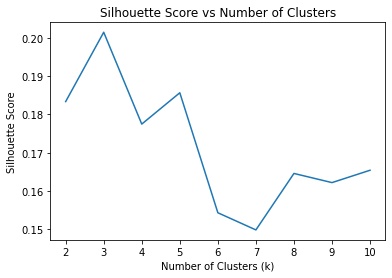

For k=2:
1    55.186722
0    44.813278
Name: count, dtype: float64

For k=3:
1    43.568465
0    38.450899
2    17.980636
Name: count, dtype: float64

For k=4:
2    35.822960
1    29.529737
0    19.917012
3    14.730290
Name: count, dtype: float64

For k=5:
2    34.024896
1    28.630705
3    18.879668
4    14.107884
0     4.356846
Name: count, dtype: float64

For k=6:
4    24.204703
5    20.331950
0    18.948824
1    18.741355
3    13.762102
2     4.011065
Name: count, dtype: float64

For k=7:
3    22.337483
0    20.608575
2    17.911480
4    14.730290
5    12.586445
6     8.022130
1     3.803596
Name: count, dtype: float64

For k=8:
5    22.406639
4    19.432918
0    18.948824
7    17.704011
2    13.139696
1     3.319502
6     2.835408
3     2.213001
Name: count, dtype: float64

For k=9:
5    19.709544
0    19.363762
1    19.225450
2    18.672199
4     9.336100
3     5.394191
6     3.181189
8     2.697095
7     2.420470
Name: count, dtype: float64

For k=10:
3    18.326418
0    17.773

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of k values
k_values = range(2, 11)

# Initialize lists to store the Silhouette scores and cluster percentages
silhouette_scores = []
cluster_percentages = []

# Iterate over different values of k
for k in k_values:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(modeling_df)
    
    # Calculate the Silhouette score
    score = silhouette_score(modeling_df, labels)
    silhouette_scores.append(score)
    
    # Calculate the percentage of each cluster
    cluster_counts = pd.Series(labels).value_counts()
    percentages = cluster_counts / len(labels) * 100
    cluster_percentages.append(percentages)

# Plot the line plot of Silhouette scores to evaluate the optimal number of clusters - the higher the score, the better
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Print the percentage of each cluster at different k numbers
for k, percentages in zip(k_values, cluster_percentages):
    print(f"For k={k}:")
    print(percentages)
    print()

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform k-means clustering with k=3
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(modeling_df)

# Get the predicted cluster labels
labels = kmeans_model.labels_

# Calculate the silhouette score for evaluation
silhouette_avg = silhouette_score(modeling_df, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.20149207815125644


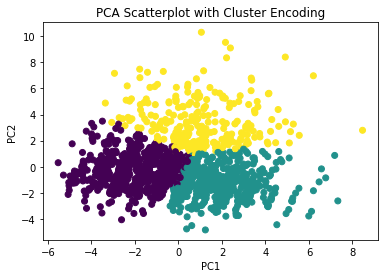

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to visualize the clusters
pca = PCA(n_components=2)
compressed_data = pca.fit_transform(modeling_df)

# Convert compressed data to a DataFrame
compressed_df = pd.DataFrame(compressed_data, columns=['PC1', 'PC2'])

# Append the cluster column using clusters
compressed_df['Cluster'] = labels

# Plot the data on a scatterplot with color encoding for the clusters
plt.scatter(compressed_df['PC1'], compressed_df['PC2'], c=compressed_df['Cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatterplot with Cluster Encoding')
plt.show()


#### Q2.2 Build a second model to segment costumers and compare the performance. (10 points)

Hierarchical clustering is a method used to group similar data points into clusters based on their proximity to each other. Unlike k-means, which requires the number of clusters to be specified in advance, hierarchical clustering builds a hierarchy of clusters without the need for predefining the number of clusters. It starts by considering each data point as a separate cluster and then iteratively merges the closest clusters together based on a chosen distance metric, such as Euclidean distance. This process continues until all data points are merged into a single cluster or until a stopping criterion is met. Hierarchical clustering can be visualized using a dendrogram, which illustrates the merging process and the hierarchical structure of the clusters. This method provides insights into the inherent structure of the data and can be useful for exploratory analysis and understanding relationships between data points.

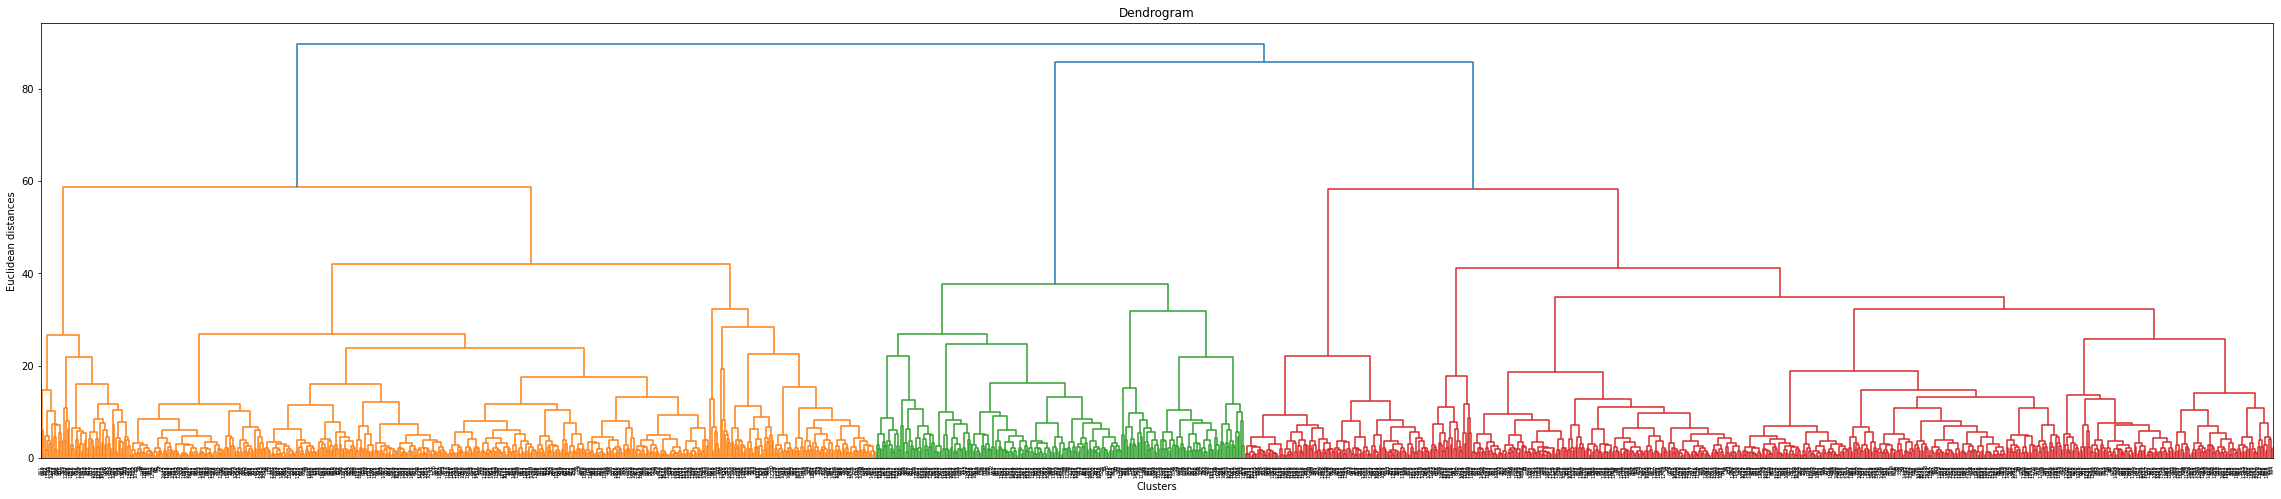

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming your modeling dataframe is named 'modeling_df'

# Generate the linkage matrix
Z = linkage(modeling_df, 'ward')

# Plot the Dendrogram
plt.figure(figsize=(40, 8))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.show()

In [35]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

Z = linkage(modeling_df, 'ward')

# Calculate the clusters
clusters = fcluster(Z, 3, criterion='maxclust')

# Calculate the silhouette score
silhouette_avg = silhouette_score(modeling_df, clusters)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")

# Calculate the percentage of data in each cluster
cluster_counts = pd.Series(clusters).value_counts(normalize=True) * 100

# Print the percentage of data in each cluster
print(cluster_counts)


Silhouette Score: 0.17729917867899048
3    46.058091
1    37.413555
2    16.528354
Name: proportion, dtype: float64


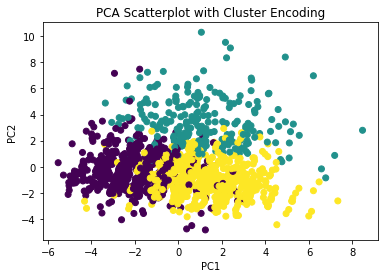

In [36]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
compressed_data = pca.fit_transform(modeling_df)

# Convert compressed data to a DataFrame
compressed_df = pd.DataFrame(compressed_data, columns=['PC1', 'PC2'])

# Append the cluster column using clusters
compressed_df['Cluster'] = clusters

# Plot the data on a scatterplot with color encoding for the clusters
import matplotlib.pyplot as plt

plt.scatter(compressed_df['PC1'], compressed_df['PC2'], c=compressed_df['Cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatterplot with Cluster Encoding')
plt.show()

The Silhouette Score assesses clustering quality by measuring how well data points belong to their assigned clusters. A higher score indicates more cohesive and well-separated clusters. In this comparison, the k-means model outperforms hierarchical clustering with a Silhouette Score of 0.2016 versus 0.1773, signifying better-defined clusters and clearer distinctions between them. Hence, based on this metric, the baseline model proves superior in identifying distinct patterns within the data. This can also be confirmed visually, k-means overlapping is much less significant in the case of the baseline model than at the second model.

#### Q2.3 Based on the analysis, suggest a number of clusters and their characteristics to the head of marketing. Please justify your decisions. (10 points)

In [37]:
# Assigning the clusters to the customer dataframe to analyze the cluster characteristics
# Instantiate KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(modeling_df)

# Assign the clusters to the customer dataframe to analyze the cluster characteristics
customer_df['Cluster'] = kmeans.predict(modeling_df)
customer_df.head(10)

,CustomerID,Quantity_Avg_Customer,Quantity_Sum_Customer,UnitPrice_Avg_Customer,UnitPrice_Sum_Customer,TransactionAmount_Avg_Customer,TransactionAmount_Sum_Customer,Recency,UniqueProducts,PurchaseCount,AvgDaysBetweenPurchases,UsualShoppingDay,UsualShoppingHour,CancelationCount,CancellationRate,IsUK,Cluster
0,12346.0,0.000000,0,1.040000,2.08,0.000000,0.00,325,1,2,0.000000,1,10,1,0.500000,1.0,1
1,12352.0,5.511905,463,3.934524,330.50,15.064405,1265.41,35,57,84,3.108434,1,14,7,0.083333,0.0,2
2,12359.0,6.370518,1599,8.805020,2210.06,24.633386,6182.98,7,214,251,1.284000,3,12,6,0.023904,0.0,0
3,12362.0,8.257576,2180,3.523826,930.29,17.672652,4665.58,2,200,264,1.091255,3,15,8,0.030303,0.0,0
4,12375.0,10.937500,175,2.475000,39.60,23.463750,375.42,2,13,16,6.333333,4,14,1,0.062500,0.0,2
5,12379.0,10.282051,401,2.220513,86.60,19.879231,775.29,81,38,39,2.289474,0,10,1,0.025641,0.0,1
6,12380.0,10.980198,1109,2.837921,286.63,23.995644,2423.56,21,76,101,1.620000,4,11,1,0.009901,0.0,1
7,12381.0,8.976744,772,3.331860,286.54,16.668140,1433.46,4,69,86,1.329412,4,9,4,0.046512,0.0,1
8,12383.0,15.947368,1515,2.435368,231.36,17.024316,1617.31,184,83,95,1.755319,2,14,1,0.010526,0.0,2
9,12384.0,4.178571,117,5.259643,147.27,14.505714,406.16,28,25,28,3.370370,2,11,3,0.107143,0.0,1


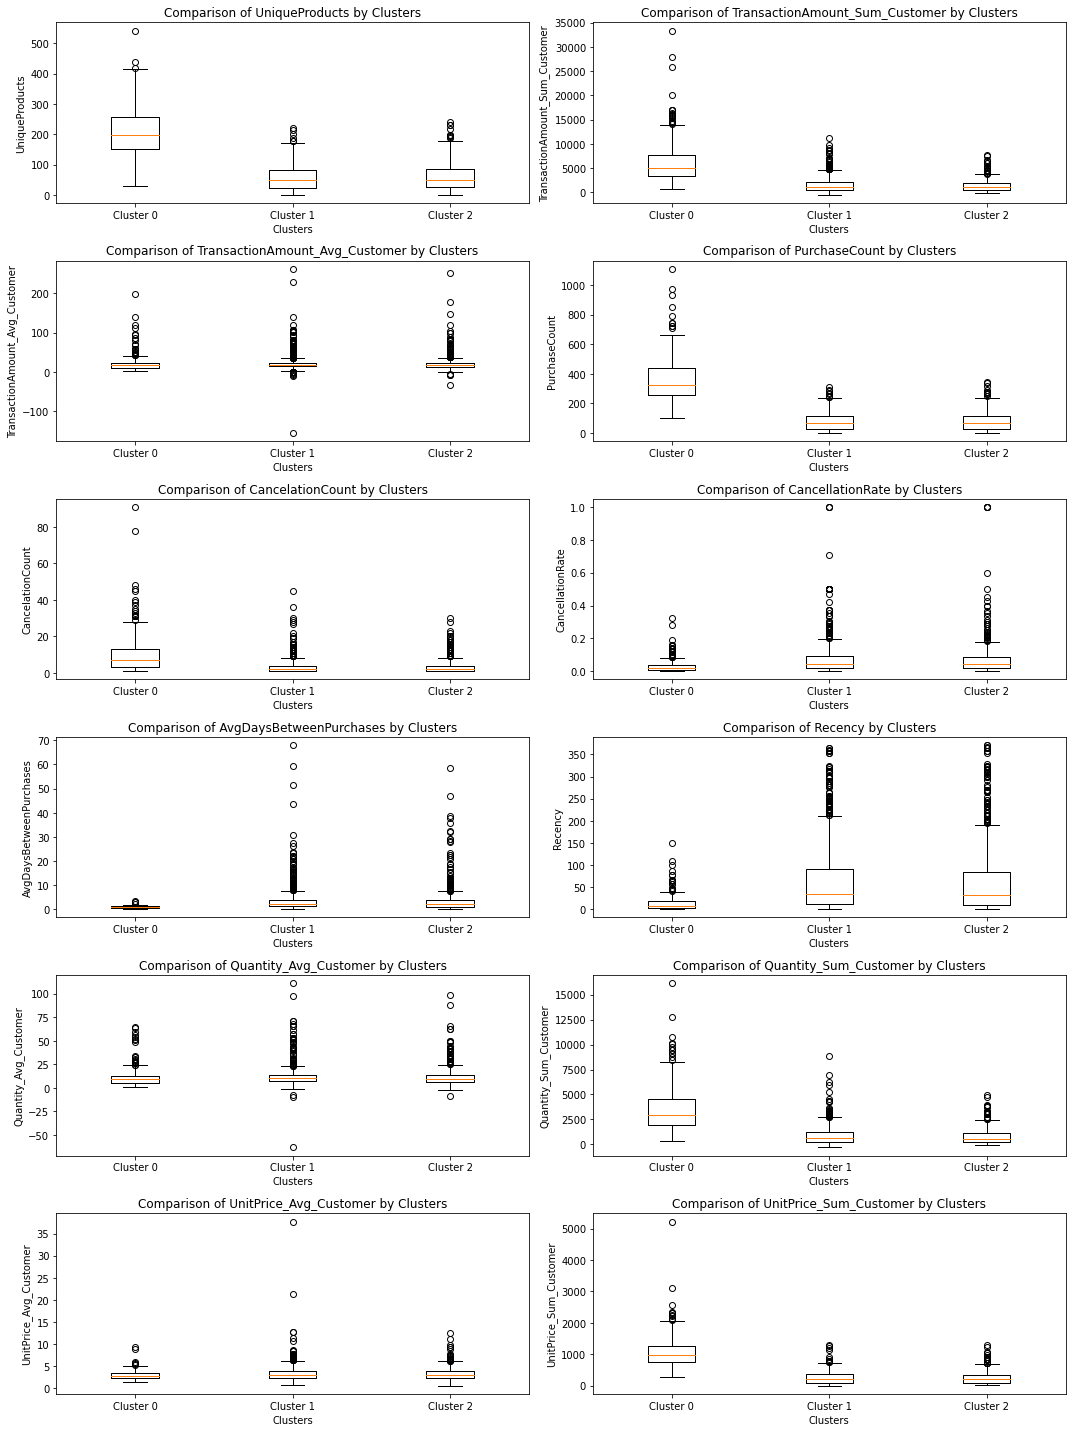

In [38]:
import matplotlib.pyplot as plt

# List of columns to plot
columns = ['UniqueProducts', 'TransactionAmount_Sum_Customer', 'TransactionAmount_Avg_Customer', 'PurchaseCount', 'CancelationCount', 'CancellationRate', 'AvgDaysBetweenPurchases', 'Recency', 'Quantity_Avg_Customer', 'Quantity_Sum_Customer', 'UnitPrice_Avg_Customer', 'UnitPrice_Sum_Customer']

# Create a figure with 6 subplots, arranged in 2 rows and 3 columns
fig, axs = plt.subplots(6, 2, figsize=(15, 20))

# Flatten the axes array
axs = axs.ravel()

# Filter the customer_df based on the clusters
clusters = [customer_df[customer_df['Cluster'] == i] for i in range(3)]

# For each column, create a boxplot
for i, column in enumerate(columns):
    # Create the boxplot
    axs[i].boxplot([cluster[column] for cluster in clusters], labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])

    # Set the title and labels
    axs[i].set_title(f'Comparison of {column} by Clusters')
    axs[i].set_xlabel('Clusters')
    axs[i].set_ylabel(column)

# Remove the unused subplot (if any)
if len(columns) < len(axs):
    for i in range(len(columns), len(axs)):
        fig.delaxes(axs[i])

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

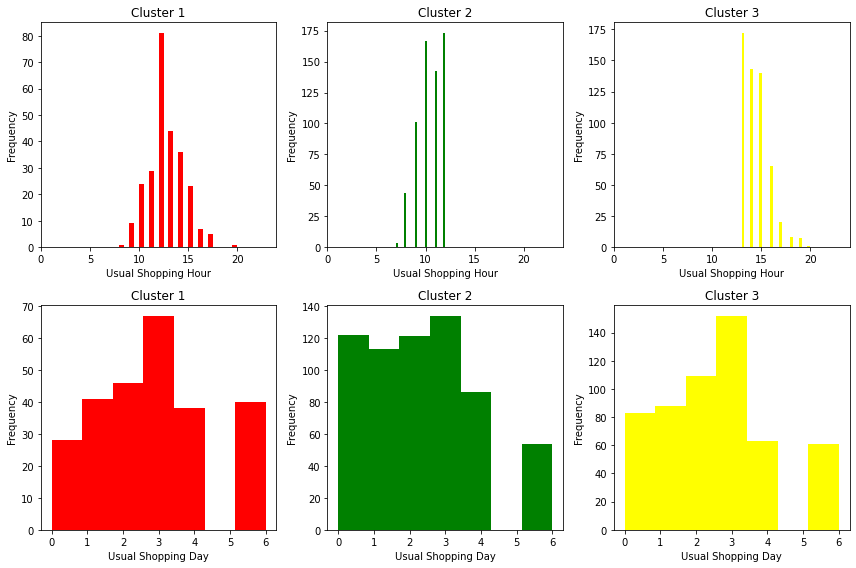

In [39]:
import matplotlib.pyplot as plt

# Define the colors for each cluster
colors = ['red', 'green', 'yellow']

# Create a figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over each cluster
for i, cluster in enumerate(clusters):
    # Plot the histogram of usual shopping hour
    axs[0, i].hist(cluster['UsualShoppingHour'], bins=24, color=colors[i])
    axs[0, i].set_title(f'Cluster {i+1}')
    axs[0, i].set_xlabel('Usual Shopping Hour')
    axs[0, i].set_ylabel('Frequency')
    axs[0, i].set_xlim([0, 24])  # Set the x-axis range to be from 0 to 24

    # Plot the histogram of usual shopping day
    axs[1, i].hist(cluster['UsualShoppingDay'], bins=7, color=colors[i])
    axs[1, i].set_title(f'Cluster {i+1}')
    axs[1, i].set_xlabel('Usual Shopping Day')
    axs[1, i].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Based on the analysis conducted, I recommend segmenting customers into three clusters. This suggestion is supported by the Silhouette Score, indicating the highest value for three clusters, and visually confirmed by the dendrogram from the Hierarchical Clustering model, where three distinct branches emerge early in the tree.

Upon comparison of these clusters, notable differences emerge. Cluster 0 comprises customers with diverse purchase patterns, exhibiting a significantly higher purchase frequency compared to other clusters, leading to higher overall spending despite similar average transaction values. While their cancellation count is elevated due to frequent transactions, in terms of cancellation rate it remains lower than in other clusters. These customers tend to opt for lower-priced products, indicating a preference for economical options, suggesting loyalty and frequent return visits. They are roughly 38% of the data.

Clusters 1 and 2 exhibit similar traits with nuanced distinctions. Customers in Cluster 2 tend to purchase more unique products and collectively spend less than those in Cluster 1. Both clusters feature individuals with infrequent shopping habits. Differences in shopping timing are apparent, with Cluster 1 showing a preference for morning shopping, while Cluster 2 leans towards afternoon purchases. Additionally, Cluster 1 demonstrates a more evenly distributed shopping pattern throughout the week, whereas Cluster 2 peaks midweek. Cluster 1 contains roughly 44% of customers, while cluster 2 has almost 17%.

Using this model and the characteristics, the marketing department will be able to deliver a more personalized marketing, and increase both sales and customer satisfaction.

## Question 3: Create a recommendation system that helps the company to increase sales (35 points)


#### Q3.1 Build the recommendation system. (25 points)

In [46]:
# Create dataframe about products for later use
products_df = df[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)
df['StockCode'] = df['StockCode'].astype(str)

# Create dataframe of purchases for later use, that contains the number of purchases for each product for each customer
df_clean = df[df['Canceled'] == 0]
purchases_df = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='InvoiceNo', aggfunc='count', fill_value=0)

# Create purchase count for products for later use
purchase_count_df = purchases_df.sum().sort_values(ascending=False).reset_index()
purchase_count_df.columns = ['StockCode', 'PurchaseCount']
purchase_count_df = purchase_count_df.sort_values(by='PurchaseCount', ascending=False)


In [41]:
# Since the data does not contain ratings, we will use the cases of repeated purchases to indicate liking of the product
# Drop canceled transactions
df_clean = df[df['Canceled'] == 0]

# Create rec_df
rec_df = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='InvoiceNo', aggfunc='count', fill_value=0)
rec_df = rec_df.applymap(lambda x: 1 if x >= 2 else 0)
print(rec_df.sum(axis=0).sum())
rec_df

62106


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
from sklearn.model_selection import train_test_split
# System code
# Since the data does not contain ratings, we will use the cases of repeated purchases to indicate liking of the product
# Drop canceled transactions
df_clean = df[df['Canceled'] == 0]

# Get unique CustomerIDs
customer_ids = df_clean['CustomerID'].unique()

# Perform train-test split on the customers to test the recommendation system
train_ids, test_ids = train_test_split(customer_ids, test_size=0.2, random_state=42)

# Create train dataframe
train_df = df_clean[df_clean['CustomerID'].isin(train_ids)]

# Create test dataframe
test_df = df_clean[df_clean['CustomerID'].isin(test_ids)]


# Create first_rec_df
first_rec_df = train_df.pivot_table(index='CustomerID', columns='StockCode', values='InvoiceNo', aggfunc='count', fill_value=0)
first_rec_df = first_rec_df.applymap(lambda x: 1 if x >= 2 else 0)

# Transpose the dataframe so that stock codes become rows
first_rec_df_transposed = first_rec_df.T

# Compute the cosine similarity matrix
first_cosine_sim_matrix = cosine_similarity(first_rec_df_transposed)

# Convert the cosine similarity matrix into a DataFrame
first_cosine_sim_df = pd.DataFrame(first_cosine_sim_matrix, index=first_rec_df.columns, columns=first_rec_df.columns)

first_cosine_sim_df.columns = first_cosine_sim_df.columns.astype(str)

# Create a secondary similarity dataframe, where liking is simply purchasing a product once (the requirements for liking are weaker)
# Create second_rec_df
second_rec_df = train_df.pivot_table(index='CustomerID', columns='StockCode', values='InvoiceNo', aggfunc='count', fill_value=0)
second_rec_df = second_rec_df.applymap(lambda x: 1 if x >= 1 else 0)

# Transpose the dataframe so that stock codes become rows
second_rec_df_transposed = second_rec_df.T

# Compute the cosine similarity matrix
second_cosine_sim_matrix = cosine_similarity(second_rec_df_transposed)

# Convert the cosine similarity matrix into a DataFrame
second_cosine_sim_df = pd.DataFrame(second_cosine_sim_matrix, index=second_rec_df.columns, columns=second_rec_df.columns)

second_cosine_sim_df.columns = second_cosine_sim_df.columns.astype(str)


In [48]:
# Define the recommender function
def recommender(user_id, n=10, mode=0):
    # Function to get similar products based on user's purchase history
    def get_similar_products(user_products, cosine_sim_df):
        similar_products = pd.DataFrame(columns=['StockCode', 'Similarity'])
        for product in user_products:
            similar_products = pd.concat([similar_products, cosine_sim_df.loc[product].rename('Similarity')], axis=1)
        similar_products = similar_products.stack().reset_index()
        similar_products.columns = ['StockCode', 'Product', 'Similarity']
        similar_products = similar_products.sort_values(by='Similarity', ascending=False)
        similar_products = similar_products[~similar_products['StockCode'].isin(user_products)]
        return similar_products.head(n)
    
    # Function to handle missing similar products
    def handle_missing_similar(similar_products, missing_count, cosine_sim_df, purchase_count_df):
        missing_similar = purchase_count_df[~purchase_count_df['StockCode'].isin(similar_products['StockCode'])].copy()
        missing_similar['Similarity'] = 1
        return missing_similar.head(missing_count)
    
    # Filter user's purchases
    og_list = purchases_df.loc[user_id][purchases_df.loc[user_id] >= 1].index.tolist()
    
    # Get similar products for the user
    similar_products = get_similar_products(og_list, first_cosine_sim_df)
    
    # Check for 0 similarity and handle missing similar products
    missing_count = similar_products[similar_products['Similarity'] == 0].shape[0]
    if missing_count > 0:
        similar_products = similar_products[similar_products['Similarity'] > 0]
        missing_similar = get_similar_products(og_list, second_cosine_sim_df)
        similar_products = pd.concat([similar_products, missing_similar], axis=0)
    
    # Check for 0 similarity again and handle missing similar products
    missing_count = similar_products[similar_products['Similarity'] == 0].shape[0]
    if missing_count > 0:
        similar_products = similar_products[similar_products['Similarity'] > 0]
        missing_similar = handle_missing_similar(similar_products, missing_count, second_cosine_sim_df, purchase_count_df)
        similar_products = pd.concat([similar_products, missing_similar], axis=0)
    
    # Get final recommendations
    final_recommendations = similar_products.head(n)['StockCode']
    
    # Return recommendations based on mode
    if mode == 0:
        print(f"Based on the purchases of {user_id}, these products are recommended:")
        recommended_products = products_df[products_df['StockCode'].isin(final_recommendations)]
        return recommended_products
    elif mode == 1:
        return final_recommendations.tolist()

# Example usage:

# Basic mode
# Known bug with this mode: sometimes it does not display all 10 recommendations, rerunning the cells in this section usually fixes this
recommendations_basic = recommender(18280.0, n=10, mode=0)
print(recommendations_basic)

# Mode 1 for testing
recommendations_mode_1 = recommender(18280.0, n=10, mode=1)
print(recommendations_mode_1)

Based on the purchases of 18280.0, these products are recommended:
     StockCode                       Description
26       22728         ALARM CLOCK BAKELIKE PINK
28       22726        ALARM CLOCK BAKELIKE GREEN
204      22730        ALARM CLOCK BAKELIKE IVORY
718      22825  DECORATIVE PLANT POT WITH FRIEZE
1364    85018D   YULETIDE IMAGES S/6 PAPER BOXES
1606     20980              36 PENCILS TUBE POSY
1727     22052         VINTAGE CARAVAN GIFT WRAP
1770     21253    SET OF PICTURE FRAME  STICKERS
1926     85118              HEART T-LIGHT HOLDER
2647     84847               FLORAL BATHROOM SET
['22726', '22728', '84847', '22730', '22825', '85118', '22052', '21253', '20980', '85018D']


In [44]:
def calculate_hit_rate(test_df, recommender, k=10):
    hit_count = 0
    total_count = 0
    skip_count = 0

    # Filter test_df to include only CustomerIDs present in purchases_df
    test_df_filtered = test_df[test_df['CustomerID'].isin(purchases_df.index)]

    for user_id in test_df_filtered['CustomerID'].unique():
        try:
            # Get the actual products the user bought
            actual_products = set(test_df_filtered[test_df_filtered['CustomerID'] == user_id]['StockCode'])

            # Get the recommended products
            recommended_products = set(recommender(user_id, n=k, mode=1))

            # Calculate the hit rate
            hits = actual_products.intersection(recommended_products)

            hit_count += len(hits)
            total_count += len(actual_products)
        except:
            # Skip the user if the recommender fails, known bug in the recommender function, when items are not found based on StockCode
            skip_count += 1
            continue

    # Print the skip count
    print(f"Skipped {skip_count} users for whom the recommender failed.")

    print(f"Hit count: {hit_count}")

    # Return the hit rate
    return hit_count / total_count if total_count > 0 else 0

# Example usage:

# Calculate the hit rate
hit_rate = calculate_hit_rate(test_df, recommender, k=10)
print(f"Hit rate: {hit_rate}")

Skipped 29 users for whom the recommender failed.
Hit count: 0
Hit rate: 0.0


In [45]:
print(test_df['CustomerID'].nunique())

867


#### Q3.2 Based on the analysis, suggest how the model can be used in marketing. Which data would you like to have to improve the results? Please justify your decisions. (10 points)

This recommender system utilizes item-based collaborative filtering to provide tailored product suggestions based on customers' purchase histories. It operates by analyzing similarities between products using a cosine similarity matrix, which helps identify items akin to those previously purchased by a customer. This enables the system to offer recommendations that complement a customer's preferences, thereby enhancing their shopping experience. The model employs a multi-step filtering process: initially recommending products based on a stringent criterion of customer 'liking,' which is defined as repeated purchase of a product. In the second step, if the initial recommendations fall short, the criterion for 'liking' is relaxed to encompass any past purchase, not necessarily repeated. Finally, any remaining slots are filled with the most popular items. This approach ensures that recommendations resonate with individual tastes while also promoting popular products. Its straightforward methodology focuses on identifying similar products without relying on intricate data science concepts, making it easily understandable and actionable for management's decision-making process.

With the model, the company can offer personalized recommendations to each customer with a purchase history, while also suggesting the most popular products to new customers. This capability can be leveraged through personalized emails or highlighted product sections on the website for logged-in users.

Despite the model's inability to generate hits within the existing database with 10 recommendations, its recommendation mechanism, based on similar products, holds potential for expanding the variety of products in the customer base, thus potentially driving sales growth. While the current evaluation yields no hits, the model's focus on suggesting analogous items suggests promise in diversifying customer purchases and broadening the company's product offerings.

To further enhance this model, gathering feedback from customers in the form of ratings would be invaluable. This feedback could provide insight into customers' opinions on different products, enabling the prediction of how a user might rate a product they haven't purchased yet. By incorporating such ratings, the recommendation engine could become even more finely tuned, offering increasingly tailored suggestions that better match individual preferences. Also a longer period of time, so more data on purchases could also increase the models performance.